# Project 2 Notebook

Imported necessary libraries

In [1]:
# Your code here - remember to use markdown cells for comments as well!
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import statsmodels
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from statsmodels.tools.eval_measures import rmse
from statsmodels.api import qqplot
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from folium.plugins import FastMarkerCluster
import folium
from sklearn.metrics import r2_score

## Defining Functions and Feature Engineering

Created functions for the model assessments

In [2]:
def sm_metrics(model, y, X):
    # import associated tools
    from statsmodels.tools.eval_measures import rmse, mse, meanabs
    
    # now generate predictions
    ypred = model.predict(X)

    # Print values
    print('Metrics:')
    # MAE
    print(f"Mean Absolute Error: {meanabs(y, ypred):.3f}")
    # MSE
    print(f"Mean Squared Error: {mse(y, ypred):.3f}")
    # RMSE
    print(f"Root Mean Squared Error: {rmse(y, ypred):.3f}")
    return

In [3]:
def sk_metrics(y, model):
    from sklearn.metrics import mean_squared_error, mean_absolute_error

    print("Metrics:")
    # R2
    print(f"R2: {r2_score(y, model):.3f}")
    # MAE
    print(f"Mean Absolute Error: {mean_absolute_error(y, model):.3f}")
    # MSE
    print(f"Mean Squared Error: {mean_squared_error(y, model):.3f}")
    # RMSE - just MSE but set squared=False
    print(f"Root Mean Squared Error: {mean_squared_error(y, model, squared=False):.3f}")
    return

In [4]:
def qq(x_test, x_train, y_test, y_train):
    # QQ plots are generally great tools for checking for normality.
    import statsmodels.api as sm
    from sklearn.linear_model import LinearRegression
    
    # Calculating residuals
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    y_hat = lr.predict(x_test)
    
    residuals = y_test - y_hat
    
    
    sm.qqplot(residuals, line = 'r');
    return

In [5]:
# evaluates the Variance Inflation Factor of X_train variables

def vif(X_train):
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    # defining an empty dataframe to capture the VIF scores
    vif = pd.DataFrame()

    # For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score
    vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]

    # label the scores with their related columns
    vif["features"] = X_train.columns
    
    # print out the vif table and return
    print(vif)
    return

In [102]:
def lr_model_metrics(x_test, x_train, y_test, y_train, cat_vars): 
    # One hot encoding cat vars
    onehot = OneHotEncoder(sparse=False, handle_unknown = 'ignore')
    x_train_cat = pd.DataFrame(onehot.fit_transform(x_train[cat_vars]))
    x_train_cat.columns = onehot.get_feature_names(cat_vars)
    x_test_cat = pd.DataFrame(onehot.transform(x_test[cat_vars]))
    x_test_cat.columns = onehot.get_feature_names(cat_vars)
    
    # Resetting indices
    x_train_cat.reset_index(drop=True, inplace=True)
    x_test_cat.reset_index(drop=True, inplace=True)
    x_train.reset_index(drop=True, inplace=True)
    x_test.reset_index(drop=True, inplace=True)
    
    # Combine dummied cat vars with scaled vars
    x_train_df = x_train_cat.join(x_train.drop(cat_vars, axis = 1))
    x_test_df = x_test_cat.join(x_test.drop(cat_vars, axis = 1))
    
    # Run linear regression model for data
    lr = LinearRegression()
    model = lr.fit(x_train_df, y_train)
    
    print('Train Data')
    sk_metrics(y_train, model.predict(x_train_df.values))
    
    print('Test Data')
    sk_metrics(y_test, model.predict(x_test_df.values))
    return x_train_df, x_test_df, model

Loaded in the kc_house_data.csv using pandas library. Some initial EDA


In [7]:
housedf = pd.read_csv('data/kc_house_data.csv')


In [8]:
housedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [9]:
housedf.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [10]:
housedf.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

Created a few dataframes for different use cases:
- **dfinit**: used to drop columns that we were not utilizing in our model/data analysis (mostly categorical columns)
- **dfrev1**: used to drop numerical columns
- **dfrevcopy**: used for testing some modeling so that I didn't have to re-run everything when I made a mistake

Also added some features to the original housedf:
- **sqft_per_bedroom**: the sqft_living divided by bedrooms value for avg sqft per bedroom
- **footprint**: the sqft_living divided by sqft_lot for relative sqft of usage
- **bedbathratio**: the number of bedrooms divided by bathrooms since these values have high multicollinearity

In [11]:
housedf.drop_duplicates(keep= 'first', inplace = True)
dfinit = housedf.drop(['id', 'date', 'yr_renovated', 'condition', 'waterfront', 'lat', 'long', 
                 'sqft_above', 'sqft_basement', 'view'], axis=1).copy()
dfrev1 = dfinit.drop(['sqft_living15', 'sqft_lot15'], axis=1).copy()
dfrevcopy = dfinit.drop(['sqft_living15', 'sqft_lot15'], axis=1).copy()
# Feature engineered sqft_per_bedroom as a data column since for our stakeholder, knowing the avg sqft per bedroom in a home
# would be useful in deciding which direction to go for homebuilding.
housedf['sqft_per_bedroom'] = housedf['sqft_living'] / housedf['bedrooms']
# Feature engineered the footprint column to visualized the relationship between sqft of living and the lot size so that our 
# stakholder would know on avg what home sizes they would be working with.
housedf['footprint'] = housedf['sqft_living'] / housedf['sqft_lot']
# Feature engineered the bedbathratio since they have decently high multicollinearity - combining them together in the bed/bath
# ratio might give us a better R^2 value
housedf['bedbathratio'] = housedf['bedrooms'] / housedf['bathrooms']
# Printed out housedf just to check that columns were added correctly
housedf

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_per_bedroom,footprint,bedbathratio
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,1955,0.0,98178,47.5112,-122.257,1340,5650,393.333333,0.208850,3.000000
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,1951,1991.0,98125,47.7210,-122.319,1690,7639,856.666667,0.354874,1.333333
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,1933,NaN,98028,47.7379,-122.233,2720,8062,385.000000,0.077000,2.000000
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,1965,0.0,98136,47.5208,-122.393,1360,5000,490.000000,0.392000,1.333333
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,1987,0.0,98074,47.6168,-122.045,1800,7503,560.000000,0.207921,1.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,2009,0.0,98103,47.6993,-122.346,1530,1509,510.000000,1.352785,1.200000
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,2014,0.0,98146,47.5107,-122.362,1830,7200,577.500000,0.397385,1.600000
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,2009,0.0,98144,47.5944,-122.299,1020,2007,510.000000,0.755556,2.666667
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,NONE,...,2004,0.0,98027,47.5345,-122.069,1410,1287,533.333333,0.670017,1.200000


We load in the demographic XLS file from which we pulled this list of unique Zipcode values that we defined as kc_zips.

In [12]:
kc_zips = [98178, 98125, 98028, 98136, 98074, 98053, 98003, 98198,
           98146, 98038, 98007, 98115, 98107, 98126, 98019, 98103, 
           98002, 98133, 98040, 98092, 98030, 98119, 98112, 98052, 
           98027, 98117, 98058, 98001, 98056, 98166, 98023, 98070, 
           98148, 98105, 98042, 98008, 98059, 98122, 98144, 98004, 
           98005, 98034, 98075, 98116, 98010, 98118, 98199, 98032, 
           98045, 98102, 98077, 98108, 98168, 98177, 98065, 98029, 
           98006, 98109, 98022, 98033, 98155, 98024, 98011, 98031, 
           98106, 98072, 98188, 98014, 98055, 98039]

In [13]:
df2 = pd.read_excel('data/demographic_spatial_join.xls')

b_series = df2.ZCTA5CE10.isin(kc_zips)
df_zips = df2[b_series]

df_names = df_zips[['ZCTA5CE10', 'NAME']]
df_names.head()


,ZCTA5CE10,NAME
0,98001,Southeast
1,98001,Southwest
2,98002,Southeast
3,98003,Southeast
4,98003,Southwest


In [14]:
df_names.NAME.value_counts()

Northeast    33
West         29
Southeast    26
Southwest    17
Shoreline    12
Name: NAME, dtype: int64

In [15]:
df_names

,ZCTA5CE10,NAME
0,98001,Southeast
1,98001,Southwest
2,98002,Southeast
3,98003,Southeast
4,98003,Southwest
...,...,...
138,98188,Southeast
139,98188,Southwest
141,98198,Southeast
142,98198,Southwest


In [16]:
# Dropping duplicates randomly, for the moment
df_names.drop_duplicates(subset=['ZCTA5CE10'], inplace=True)
df_names.ZCTA5CE10

<ipython-input-16-af7d0a158eea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_names.drop_duplicates(subset=['ZCTA5CE10'], inplace=True)


0      98001
2      98002
3      98003
5      98004
6      98005
       ...  
131    98177
135    98178
138    98188
141    98198
143    98199
Name: ZCTA5CE10, Length: 70, dtype: int64

In [17]:
# lists of zipcodes
northeast = df_names.query('NAME=="Northeast"')['ZCTA5CE10'].to_list()
west = df_names.query('NAME=="West"')['ZCTA5CE10'].to_list()
shoreline = df_names.query('NAME=="Shoreline"')['ZCTA5CE10'].to_list()
southwest = df_names.query('NAME=="Southwest"')['ZCTA5CE10'].to_list()
southeast = df_names.query('NAME=="Southeast"')['ZCTA5CE10'].to_list()
print("Northeast: ", northeast)
print("Shoreline: ", shoreline)

Northeast:  [98004, 98005, 98006, 98007, 98008, 98011, 98014, 98019, 98024, 98027, 98028, 98029, 98033, 98034, 98038, 98039, 98040, 98045, 98052, 98053, 98056, 98059, 98065, 98072, 98074, 98075, 98077]
Shoreline:  [98125, 98133, 98155, 98177]


In [18]:
# Create new  DF for revisions, change type
dfrev2 = dfrev1.copy()
#dfrev2 = dfrev2.astype({"zipcode": str})
# use lists to make categorical bins
dfrev2['zipcode'] = dfrev2.zipcode.replace(to_replace=northeast, value = "Northeast")
dfrev2['zipcode'] = dfrev2.zipcode.replace(to_replace=west, value = "West")
dfrev2['zipcode'] = dfrev2.zipcode.replace(to_replace=shoreline, value = "Shoreline")
dfrev2['zipcode'] = dfrev2.zipcode.replace(to_replace=southwest, value = "Southwest")
dfrev2['zipcode'] = dfrev2.zipcode.replace(to_replace=southeast, value = "Southeast")

dfrev2.zipcode.value_counts()

Northeast    8560
West         4442
Southeast    4126
Southwest    2866
Shoreline    1603
Name: zipcode, dtype: int64

# Correlation and Heatmap Visualization

Visualized correlation between variables using .corr() method, then plotted the correlation out for easier visualization on
the sns.heatmap

In [19]:
housedf.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_per_bedroom,footprint,bedbathratio
id,1.000000,-0.016772,0.001150,0.005162,-0.012241,-0.131911,0.018608,-0.010799,0.021617,-0.012010,-0.008211,-0.001798,0.020672,-0.002701,-0.138557,-0.011922,0.088238,-0.014457
price,-0.016772,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.605368,0.053953,0.129599,-0.053402,0.306692,0.022036,0.585241,0.082845,0.580109,0.123063,-0.249948
bedrooms,0.001150,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,0.479386,0.155670,0.018495,-0.154092,-0.009951,0.132054,0.393406,0.030690,-0.024076,0.026798,0.209444
bathrooms,0.005162,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.686668,0.507173,0.051050,-0.204786,0.024280,0.224903,0.569884,0.088303,0.517415,0.287015,-0.653476
sqft_living,-0.012241,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.876448,0.318152,0.055660,-0.199802,0.052155,0.241214,0.756402,0.184342,0.755398,0.076988,-0.324152
sqft_lot,-0.131911,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.184139,0.052946,0.004513,-0.129586,-0.085514,0.230227,0.144763,0.718204,0.190583,-0.252601,-0.050648
floors,0.018608,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.523989,0.489193,0.003535,-0.059541,0.049239,0.125943,0.280102,-0.010722,0.290654,0.556700,-0.374139
sqft_above,-0.010799,0.605368,0.479386,0.686668,0.876448,0.184139,0.523989,1.000000,0.424037,0.022137,-0.261570,-0.001199,0.344842,0.731767,0.195077,0.671149,0.051612,-0.317922
yr_built,0.021617,0.053953,0.155670,0.507173,0.318152,0.052946,0.489193,0.424037,1.000000,-0.225209,-0.347210,-0.148370,0.409993,0.326377,0.070777,0.257801,0.279053,-0.437429
yr_renovated,-0.012010,0.129599,0.018495,0.051050,0.055660,0.004513,0.003535,0.022137,-0.225209,1.000000,0.069846,0.032145,-0.072156,-0.000247,0.003852,0.063348,-0.001743,-0.034499


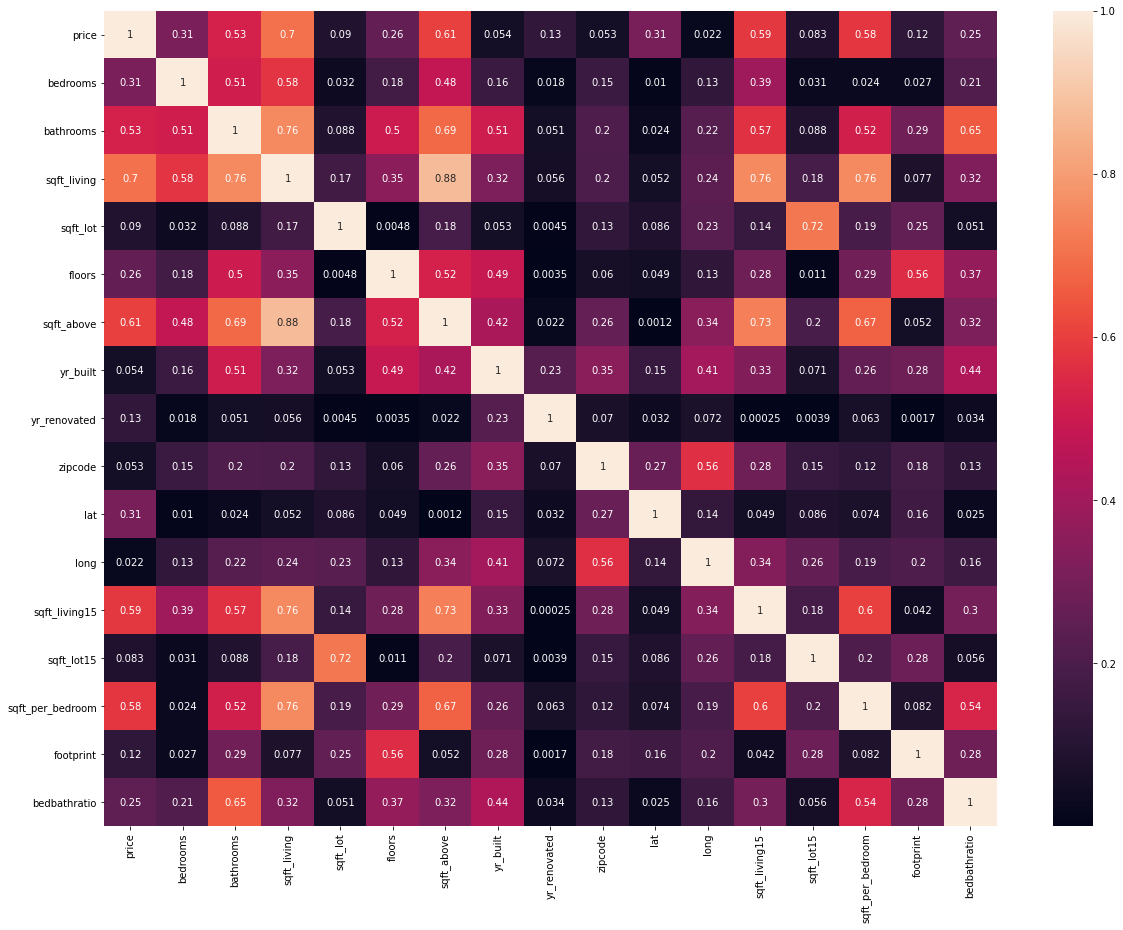

In [20]:
plt.figure(figsize = (20,15))
sns.heatmap(housedf.drop(['id'], axis = 1).corr().abs(), annot=True);

# Model Creation and Application

Created training and test datasets for the housedf dataframe. Utilized a 80 / 20 split.

In [21]:
y = housedf['price']
X = housedf[['bedrooms','bathrooms','sqft_living','sqft_lot','floors', 'yr_built', 'zipcode',
             'sqft_per_bedroom', 'footprint', 'bedbathratio']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)

## Dummy Regressor

Created a Dummy Regressor on the mean for use as our baseline model. 
- We used the predict function and saw that it printed out an array filled with the same values
- We then checked the score to see that it gave us a 0 value, so we know that this is the baseline we will compare our other models to.

In [22]:
#Dummy Regressor

basemodel = DummyRegressor(strategy = 'mean')
basemodel.fit(X_train, y_train)
basemodel.predict(X_train)

array([540946.37500724, 540946.37500724, 540946.37500724, ...,
       540946.37500724, 540946.37500724, 540946.37500724])

In [23]:
basemodel.score(X_train, y_train)

0.0

## StandardScaler and OneHotEncoder

Created a StandardScalar for our dataset because we had data values such as 1 bedroom vs. thousands of sqft

In [24]:
X_train_plus_y = pd.concat((X_train, y_train), axis=1)
X_test_plus_y = pd.concat((X_test, y_test), axis=1)
ss = StandardScaler()
ss.fit(X_train)

StandardScaler()

Created a OneHotEncoder for our initial model 

In [25]:
ohe = OneHotEncoder()
ohe.fit_transform(X_train)

<17277x26611 sparse matrix of type '<class 'numpy.float64'>'
	with 172770 stored elements in Compressed Sparse Row format>

Created a training data sat based on the StandardScalar values and our training/test split

In [26]:
# Training dataset
X_train_scaled = pd.DataFrame(ss.transform(X_train))
X_train_scaled.columns = X.columns
y_train.reset_index(drop=True,inplace=True)
X_train_scaled_plus_y = pd.concat((X_train_scaled, y_train), axis=1)
X_train.reset_index(drop=True, inplace=True)

Created the test dataset based on our StandardScalar values and our training/test split

In [27]:
# Testing dataset
X_test_scaled = pd.DataFrame(ss.transform(X_test))
X_test_scaled.columns = X.columns
y_test.reset_index(drop=True,inplace=True)
X_test_scaled_plus_y = pd.concat((X_test_scaled,y_test),axis=1)
X_test.reset_index(drop=True, inplace=True)

In [28]:
X_test

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,zipcode,sqft_per_bedroom,footprint,bedbathratio
0,4,2.50,1770,5000,2.0,2004,98038,442.500000,0.354000,1.600000
1,3,1.00,1180,5002,1.5,1946,98155,393.333333,0.235906,3.000000
2,4,2.50,2750,4800,2.0,1905,98103,687.500000,0.572917,1.600000
3,4,2.50,2310,5526,2.0,2003,98074,577.500000,0.418024,1.600000
4,3,2.00,1520,5040,2.0,1977,98177,506.666667,0.301587,1.500000
...,...,...,...,...,...,...,...,...,...,...
4315,4,2.50,2480,16360,1.0,1959,98028,620.000000,0.151589,1.600000
4316,3,2.50,1490,2478,3.0,2009,98133,496.666667,0.601291,1.200000
4317,4,2.50,2180,7203,2.0,1989,98059,545.000000,0.302652,1.600000
4318,5,3.00,3620,12778,1.0,1964,98006,724.000000,0.283299,1.666667


## First Model

Created our first model based on the values in our heatmap that had the highest correlation with price, in this case that was the sqft_living + bedrooms + floors columns. We will then use this first model to check and see if the predictors have any significant impact on the price of the homes.

In [29]:
# Keep first model as sqft_living + bedrooms + floors to show that was our first model and how we progressed
# 2nd model should be 'price ~ sqft_living + bedrooms + sqft_per_bedroom + footprint' to show the increase of R^2
formula = 'price ~  sqft_living + bedrooms + floors'
model = ols(formula, X_train_scaled_plus_y).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     5874.
Date:                Thu, 17 Feb 2022   Prob (F-statistic):               0.00
Time:                        15:29:24   Log-Likelihood:            -2.3986e+05
No. Observations:               17277   AIC:                         4.797e+05
Df Residuals:                   17273   BIC:                         4.798e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    5.409e+05   1970.511    274.521      0.000    5.37e+05    5.45e+05
sqft_living  2.882e+05   2530.414    113.894      0.000    2.83e+05    2.93e+05
bedrooms    -5.411e+04   2402.875    -22.520      0.000   -5.88e+04   -4.94e+04
floors       1412.8026   2110.123      0.670      0.503   -2723.252    5548.857
==============================================================================
Omnibus:                    11809.269   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           435749.399
Skew:                           2.803   Prob(JB):                         0.00
Kurtosis:                      26.956   Cond. No.                         2.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

After running the model, we see that sqft_living and bedrooms are a significant factor in determining the price of a home. Since the p-value of floors > 0.05, we can say that floors are not a significant factor in determining the price of a home. This pertains to our business question since the lots of land themselves are expensive, but homes are cheaper to build vertically.

Called the functions we defined earlier to find the metrics of our model. We prioritize/focus on RMSE because it provides us with more accuracy. The values in this case make sense since we are dealing with homes that are in the hundreds of thousands range.

sqftliving_coef = model.params.values[1]
bedrooms_coef = model.params.values[]

In [30]:
sm_metrics(model, y_test, X_test_scaled)

Metrics:
Mean Absolute Error: 169584.127
Mean Squared Error: 64475389966.508
Root Mean Squared Error: 253920.046


We then calculate the predicted values of our models to calculate the residuals and see if our models were implemented correctly.

In [31]:
y_hat = model.predict(X_train_scaled)
y_pred = model.predict(X_test_scaled)

We calculate the residuals

In [32]:
residuals = (y_train - y_hat)
print(residuals)

0        134054.190256
1       -177151.427931
2        -39418.666228
3        211972.734232
4       -284322.633742
             ...      
17272   -108179.962734
17273    -18228.613749
17274   -141713.668295
17275    -61076.700318
17276     34848.286680
Length: 17277, dtype: float64


logged_y_test = np.log(abs(y_pred))
logged_y_train = np.log(abs(y_hat))

plt.figure(figsize = (20,15))
plt.scatter(logged_y_train, y_train - logged_y_train, label = 'Training Set')
plt.scatter(logged_y_test, np.log(abs(y_test)) - logged_y_test, label = 'Test Set')

plt.axhline(y = 0, color = 'red', label = '0')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.legend()
plt.show()

Then we plot on a qqplot to visualize the residuals and see where our error lies

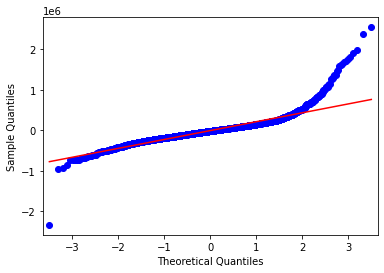

In [33]:
qq(X_test_scaled, X_train_scaled, y_test, y_train)

Plotted a heteroskedasticity plot for visualization of any recognizable patterns to check if our model was ran correctly.

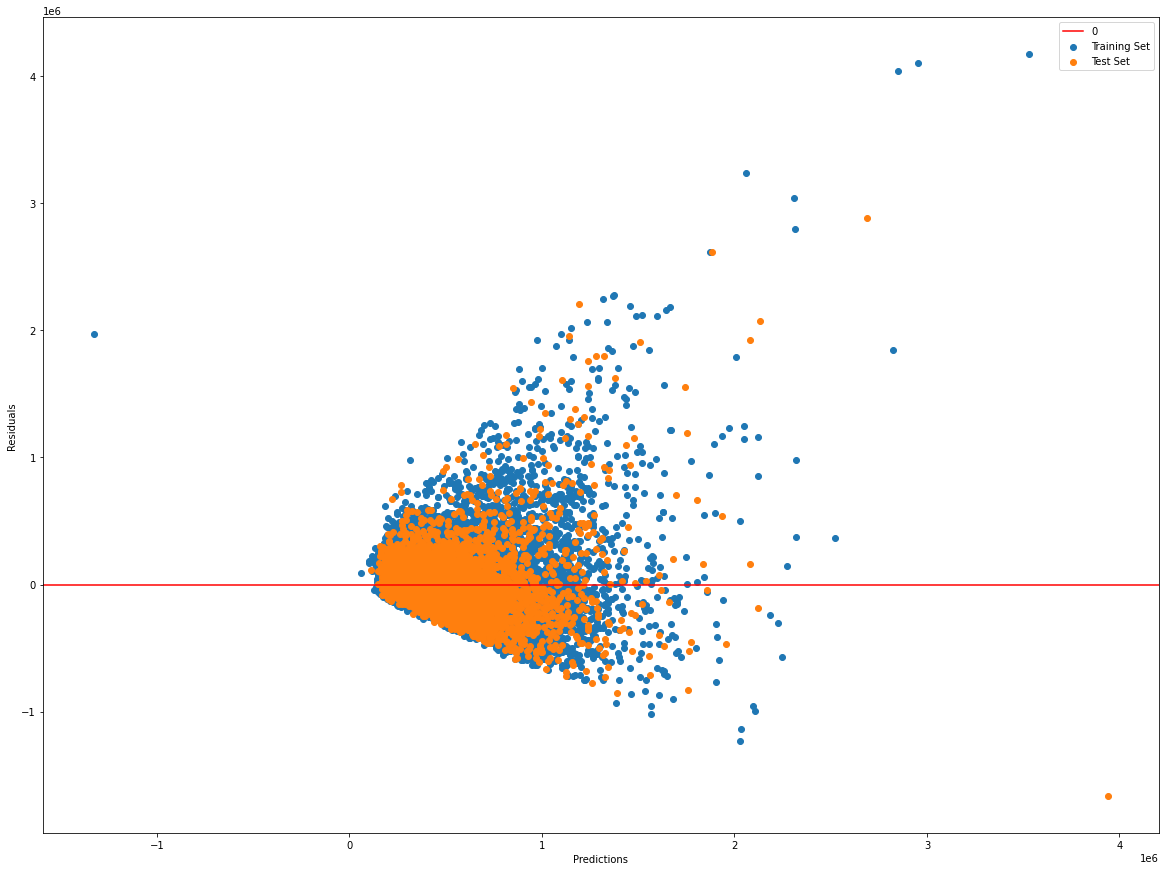

In [34]:
plt.figure(figsize = (20,15))
plt.scatter(y_hat, y_train - y_hat, label = 'Training Set')
plt.scatter(y_pred, y_test - y_pred, label = 'Test Set')

plt.axhline(y = 0, color = 'red', label = '0')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [35]:
X_train_scaled.corr()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,zipcode,sqft_per_bedroom,footprint,bedbathratio
bedrooms,1.000000,0.509423,0.571636,0.026344,0.178529,0.154396,-0.152053,-0.024644,0.030371,0.217513
bathrooms,0.509423,1.000000,0.752564,0.085556,0.503355,0.511066,-0.205060,0.517643,0.289180,-0.653090
sqft_living,0.571636,0.752564,1.000000,0.170260,0.356378,0.320881,-0.201041,0.759121,0.077961,-0.324053
sqft_lot,0.026344,0.085556,0.170260,1.000000,-0.001869,0.053034,-0.128976,0.194870,-0.250546,-0.049564
floors,0.178529,0.503355,0.356378,-0.001869,1.000000,0.488497,-0.058795,0.293768,0.553484,-0.373462
yr_built,0.154396,0.511066,0.320881,0.053034,0.488497,1.000000,-0.347291,0.261316,0.279235,-0.440836
zipcode,-0.152053,-0.205060,-0.201041,-0.128976,-0.058795,-0.347291,1.000000,-0.124074,0.177918,0.126029
sqft_per_bedroom,-0.024644,0.517643,0.759121,0.194870,0.293768,0.261316,-0.124074,1.000000,0.080342,-0.537891
footprint,0.030371,0.289180,0.077961,-0.250546,0.553484,0.279235,0.177918,0.080342,1.000000,-0.278224
bedbathratio,0.217513,-0.653090,-0.324053,-0.049564,-0.373462,-0.440836,0.126029,-0.537891,-0.278224,1.000000


We then check the VIF to see if we missed anything about multicollinearity between the variables.

In [36]:
vif(X_train_scaled)

         VIF          features
0   8.133196          bedrooms
1  10.414278         bathrooms
2  15.034290       sqft_living
3   1.142210          sqft_lot
4   1.955622            floors
5   1.739823          yr_built
6   1.276777           zipcode
7   9.195762  sqft_per_bedroom
8   1.764403         footprint
9   6.343995      bedbathratio


## Second Model - reducing complexity

We engineered this feature so as to reduce the complexity of this model and get rid of discrete variables. We saw that some of the features we engineered increased multicollinearity so we decided not to use them.

In [37]:
formula = 'price ~  sqft_living + sqft_per_bedroom + footprint + bedbathratio'
model = ols(formula, X_train_scaled_plus_y).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     4354.
Date:                Thu, 17 Feb 2022   Prob (F-statistic):               0.00
Time:                        15:29:24   Log-Likelihood:            -2.3992e+05
No. Observations:               17277   AIC:                         4.798e+05
Df Residuals:                   17272   BIC:                         4.799e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         5.409e+05   1976.419    273.700      0.000    5.37e+05    5.45e+05
sqft_living       2.203e+05   3080.842     71.492      0.000    2.14e+05    2.26e+05
sqft_per_bedroom  5.374e+04   3469.775     15.489      0.000    4.69e+04    6.05e+04
footprint         2.854e+04   2070.744     13.781      0.000    2.45e+04    3.26e+04
bedbathratio        1.7e+04   2476.960      6.865      0.000    1.21e+04    2.19e+04
==============================================================================
Omnibus:                    12444.927   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           551350.015
Skew:                           2.973   Prob(JB):                         0.00
Kurtosis:                      30.029   Cond. No.                         3.32
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
vif(X_train_scaled[['sqft_living', 'sqft_per_bedroom', 'footprint', 'bedbathratio']])

        VIF          features
0  2.429858       sqft_living
1  3.082085  sqft_per_bedroom
2  1.097728         footprint
3  1.570652      bedbathratio


<Figure size 1440x1080 with 0 Axes>

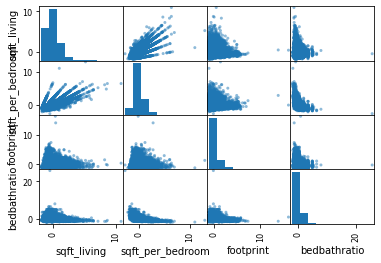

In [39]:
plt.figure(figsize = (20,15))
pd.plotting.scatter_matrix(X_train_scaled[['sqft_living', 'sqft_per_bedroom', 'footprint', 'bedbathratio']]);

In [61]:
formula2 = 'price ~  sqft_living + sqft_per_bedroom + footprint + bedbathratio'
model2 = ols(formula2, X_train_plus_y).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     4354.
Date:                Thu, 17 Feb 2022   Prob (F-statistic):               0.00
Time:                        15:39:07   Log-Likelihood:            -2.3992e+05
No. Observations:               17277   AIC:                         4.798e+05
Df Residuals:                   17272   BIC:                         4.799e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -1.93e+05   1.26e+04    -15.347      0.000   -2.18e+05   -1.68e+05
sqft_living        240.5972      3.365     71.492      0.000     234.001     247.194
sqft_per_bedroom   248.7397     16.059     15.489      0.000     217.263     280.217
footprint         1.062e+05   7706.949     13.781      0.000    9.11e+04    1.21e+05
bedbathratio      2.561e+04   3731.289      6.865      0.000    1.83e+04    3.29e+04
==============================================================================
Omnibus:                    12444.927   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           551350.015
Skew:                           2.973   Prob(JB):                         0.00
Kurtosis:                      30.029   Cond. No.                     1.61e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

x_cols = ['sqft_living', 'sqft_per_bedroom', 'footprint', 'bedbathratio']
for i in x_cols:
    X_train_scaled[i] = X_train_scaled[i].map(lambda x: np.log(abs(x)))
pd.plotting.scatter_matrix(X_train_scaled[['sqft_living', 'sqft_per_bedroom', 'footprint', 'bedbathratio']]);

for i in x_cols:
    X_test_scaled[i] = X_test_scaled[i].map(lambda x: np.log(abs(x)))
pd.plotting.scatter_matrix(X_test_scaled[['sqft_living', 'sqft_per_bedroom', 'footprint', 'bedbathratio']]);

We now run the second model to see if there were any changes to the R^2 value. We also wanted to test and see if keeping the bedrooms/bathrooms variables would reduce the complexity of our models. Removing the bedrooms variable in our model reduces our R^2 value by 0.015. 

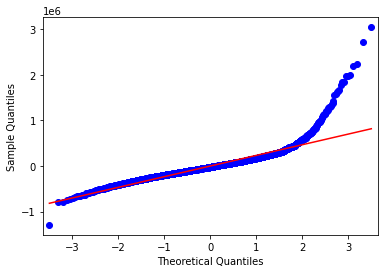

In [41]:
qq(X_test_scaled[['sqft_living', 'sqft_per_bedroom', 'footprint', 'bedbathratio']],
   X_train_scaled[['sqft_living', 'sqft_per_bedroom', 'footprint', 'bedbathratio']], y_test, y_train)

In [42]:
y_hat1 = model.predict(X_train[['sqft_living', 'sqft_per_bedroom', 'footprint', 'bedbathratio']])
y_pred1 = model.predict(X_test[['sqft_living', 'sqft_per_bedroom', 'footprint', 'bedbathratio']])

In [43]:
print(y_pred1.isnull().value_counts())
print(y_test.isnull().value_counts())
ybar = y_test - y_pred1
print(ybar.isnull().value_counts())

False    4320
dtype: int64
False    4320
Name: price, dtype: int64
False    4320
dtype: int64


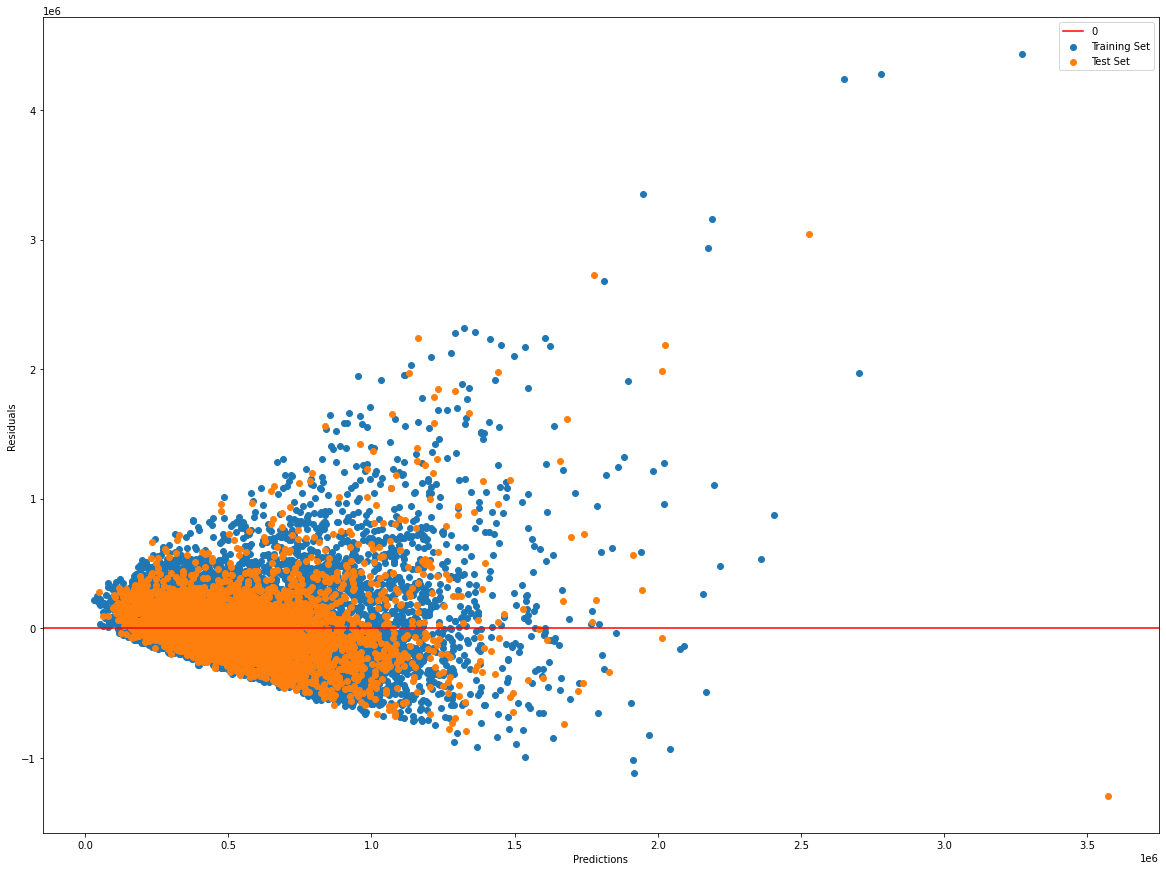

In [44]:
plt.figure(figsize = (20,15))
plt.scatter(y_hat1, y_train - y_hat1, label = 'Training Set')
plt.scatter(y_pred1, y_test - y_pred1, label = 'Test Set')

plt.axhline(y = 0, color = 'red', label = '0')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [45]:
ylog_test = np.log(abs(y_pred1))
ylog_train = np.log(abs(y_hat1))

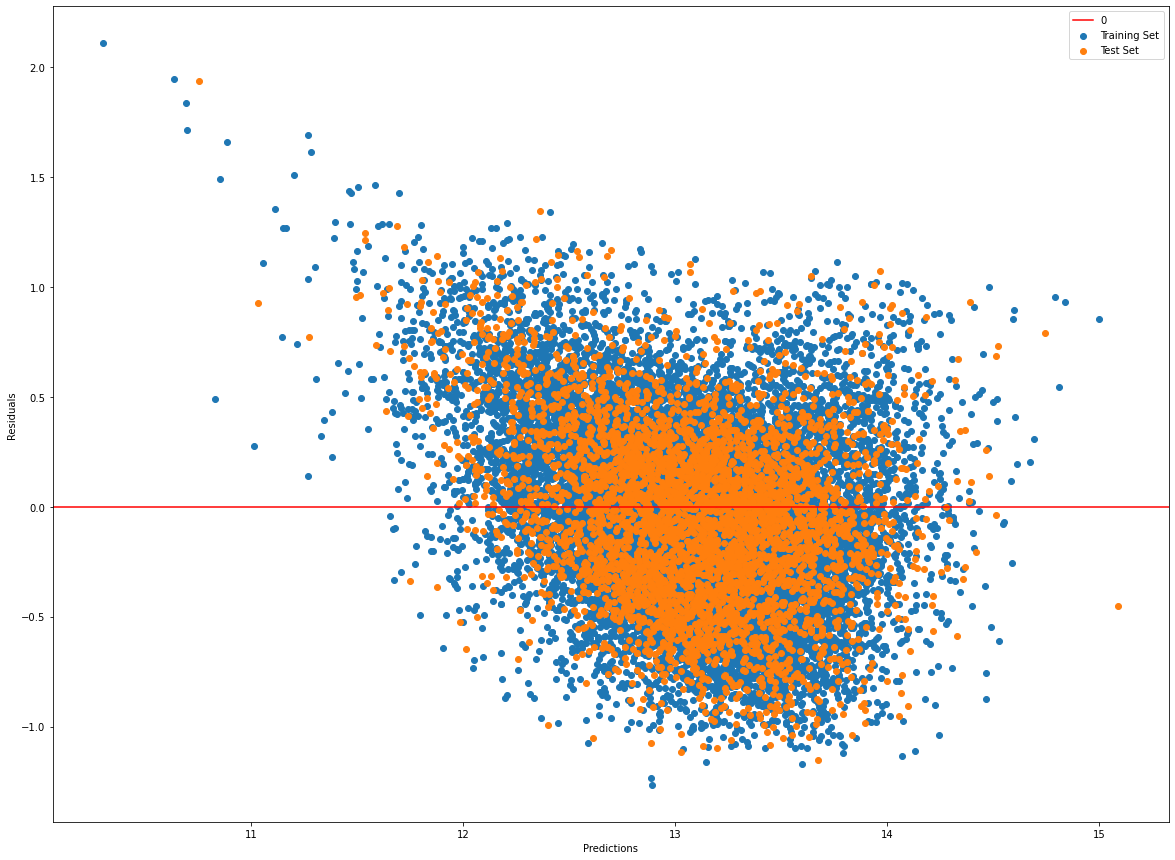

In [49]:
plt.figure(figsize = (20,15))
plt.scatter(ylog_train, np.log(abs(y_train)) - ylog_train, label = 'Training Set')
plt.scatter(ylog_test, np.log(abs(y_test)) - ylog_test, label = 'Test Set')

plt.axhline(y = 0, color = 'red', label = '0')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [50]:
model2.params

Intercept          -193006.506017
sqft_living            240.597198
sqft_per_bedroom       248.739665
footprint           106212.265597
bedbathratio         25613.591120
dtype: float64

In [62]:
sm_metrics(model2, y_train, X_train)

Metrics:
Mean Absolute Error: 170311.199
Mean Squared Error: 67468439768.192
Root Mean Squared Error: 259746.876


In [65]:
sm_metrics(model2, y_test, X_test)

Metrics:
Mean Absolute Error: 168308.110
Mean Squared Error: 64746046225.220
Root Mean Squared Error: 254452.444


In [53]:
# Seperating coefficient values from model summary into respective variables
sqftliving_coef = round(model.params.values[1], 2)
sqftperbedroom_coef = round(model.params.values[2], 2)
footprint_coef = round(model.params.values[3] / 1000, 2)
bedbathratio_coef = round(model.params.values[4] / 1000, 2)
sqftliving_coef

240.6

In [55]:
# Unlogging variables (taking variables to natural exponent to find scaled coefficients)
import math
sqft_pct_increase = (math.exp(sqftliving_coef) - 1) * 100
sqft_per_bedroom_pct_increase = (math.exp(sqftperbedroom_coef) - 1) * 100
footprint_coef_pct_increase = (math.exp(footprint_coef) - 1) * 100
bedbathratio_coef_pct_increase = (math.exp(bedbathratio_coef) - 1) * 100
sqft_pct_increase

3.099219571350648e+106

## Model 3

In [58]:
formula3 = 'price ~  sqft_living + sqft_per_bedroom'
model3 = ols(formula3, X_train_plus_y).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     8510.
Date:                Thu, 17 Feb 2022   Prob (F-statistic):               0.00
Time:                        15:35:26   Log-Likelihood:            -2.4001e+05
No. Observations:               17277   AIC:                         4.800e+05
Df Residuals:                   17274   BIC:                         4.801e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -9.454e+04   6031.466    -15.674      0.000   -1.06e+05   -8.27e+04
sqft_living        245.5396      3.335     73.615      0.000     239.002     252.077
sqft_per_bedroom   201.1258     14.132     14.232      0.000     173.425     228.826
==============================================================================
Omnibus:                    12274.680   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           520725.641
Skew:                           2.925   Prob(JB):                         0.00
Kurtosis:                      29.251   Cond. No.                     7.16e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [59]:
sm_metrics(model3, y_train, X_train)

Metrics:
Mean Absolute Error: 172693.467
Mean Squared Error: 68246302116.105
Root Mean Squared Error: 261239.932


In [60]:
sm_metrics(model3, y_test, X_test)

Metrics:
Mean Absolute Error: 170805.475
Mean Squared Error: 65423939839.562
Root Mean Squared Error: 255781.039


## Training/Test split to see if these new predictors are relevant to our model

We then created a new training/test split to see if we should add these predictors to our model or not. We did not want to affect our original model so we created a new test model to see the effect of adding another categorical column 'grade' to our dataframe.

## Model 4

In [66]:
y1 = dfrev2['price']
X1 = dfrev2[['bedrooms','bathrooms','sqft_living','sqft_lot','floors', 'yr_built', 'zipcode', 'grade']]
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=56)

Created DummyRegressor similar to how we did it for our first model.

In [67]:
X1_train_cont = X1_train.drop(['zipcode', 'grade'], axis = 1).copy()
X1_test_cont = X1_test.drop(['zipcode', 'grade'], axis = 1).copy()
ss1 = StandardScaler()
ss1.fit(X1_train_cont)

X1_train_scaled = ss1.transform(X1_train_cont)
X1_test_scaled = ss1.transform(X1_test_cont)

#Dummy Regressor

basemodel1 = DummyRegressor(strategy = 'mean')
basemodel1.fit(X1_train, y1_train)
basemodel1.predict(X1_train)

array([540946.37500724, 540946.37500724, 540946.37500724, ...,
       540946.37500724, 540946.37500724, 540946.37500724])

Dropped the numerical columns from our dataframe so that we could only focus on and OneHotEncode the categorical values we pulled from our demographics XLS

In [68]:
X1_cat = X1_train[['zipcode', 'grade']]
ohe1 = OneHotEncoder(sparse = False)
ohe_df = pd.DataFrame(ohe1.fit_transform(X1_cat))

In [69]:
ohe_df.columns = ohe1.get_feature_names(['zipcode', 'grade'])

In [70]:
type(ss1)

sklearn.preprocessing._data.StandardScaler

In [71]:
X1_train_df = pd.DataFrame(X1_train_scaled)
X1_train_df.columns = X1_train_cont.columns.tolist()

In [72]:
X1_train_df

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built
0,-0.404166,-0.148210,-0.591864,-0.174771,-0.917505,1.123192
1,0.670108,0.832246,0.489562,-0.020598,0.937801,0.884897
2,-0.404166,0.178609,-0.307853,-0.201845,0.937801,0.408307
3,0.670108,0.505427,0.631567,-0.274556,0.937801,-2.076770
4,0.670108,0.832246,2.128085,-0.115790,0.937801,-0.953379
...,...,...,...,...,...,...
17272,-1.478441,0.178609,-0.482629,-0.309172,0.937801,0.306180
17273,1.744382,1.485883,1.319747,-0.208081,0.937801,1.395529
17274,-0.404166,1.485883,1.778533,0.567548,0.937801,0.918939
17275,0.670108,-0.475029,-0.602787,-0.151807,0.010148,-0.102325


In [73]:
ohe_df.head()

,zipcode_Northeast,zipcode_Shoreline,zipcode_Southeast,zipcode_Southwest,zipcode_West,grade_10 Very Good,grade_11 Excellent,grade_12 Luxury,grade_13 Mansion,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [74]:
X1_cat

,zipcode,grade
8192,Shoreline,8 Good
18780,Northeast,8 Good
4957,Northeast,8 Good
1168,West,8 Good
15335,Shoreline,8 Good
...,...,...
9338,Shoreline,8 Good
13730,Northeast,9 Better
3264,Northeast,10 Very Good
399,Southeast,7 Average


Created a dataframe with the new OHE values for our categorical columns from housedf, ad we added the price column from our original dataframe to the OHE dataframe to check for correlation between these variables and if they had an effect on home pricing.

In [75]:
combined_df = ohe_df.join(X1_train_df)
# combined_df.dropna(inplace = True)
combined_df

,zipcode_Northeast,zipcode_Shoreline,zipcode_Southeast,zipcode_Southwest,zipcode_West,grade_10 Very Good,grade_11 Excellent,grade_12 Luxury,grade_13 Mansion,grade_4 Low,...,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,-0.404166,-0.148210,-0.591864,-0.174771,-0.917505,1.123192
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.670108,0.832246,0.489562,-0.020598,0.937801,0.884897
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,-0.404166,0.178609,-0.307853,-0.201845,0.937801,0.408307
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.670108,0.505427,0.631567,-0.274556,0.937801,-2.076770
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.670108,0.832246,2.128085,-0.115790,0.937801,-0.953379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17272,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,-1.478441,0.178609,-0.482629,-0.309172,0.937801,0.306180
17273,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.744382,1.485883,1.319747,-0.208081,0.937801,1.395529
17274,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.404166,1.485883,1.778533,0.567548,0.937801,0.918939
17275,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.670108,-0.475029,-0.602787,-0.151807,0.010148,-0.102325


In [76]:
combined_df.corr()

,zipcode_Northeast,zipcode_Shoreline,zipcode_Southeast,zipcode_Southwest,zipcode_West,grade_10 Very Good,grade_11 Excellent,grade_12 Luxury,grade_13 Mansion,grade_4 Low,...,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built
zipcode_Northeast,1.000000,-0.229578,-0.392327,-0.317999,-0.414327,0.164717,0.117355,0.053578,0.007630,0.001459,...,-0.162514,-0.159235,0.043572,0.158288,0.175478,0.273140,0.317908,0.110997,0.108523,0.360141
zipcode_Shoreline,-0.229578,1.000000,-0.136507,-0.110646,-0.144162,-0.055653,-0.037506,-0.007378,0.019168,-0.010541,...,0.040858,0.067950,-0.013586,-0.060654,-0.038443,-0.103396,-0.083594,-0.042083,-0.094373,-0.092777
zipcode_Southeast,-0.392327,-0.136507,1.000000,-0.189083,-0.246360,-0.077874,-0.054909,-0.028241,-0.012191,0.013731,...,0.028627,0.100784,-0.026789,-0.066623,0.010241,-0.060813,-0.085776,0.048762,-0.090932,0.090581
zipcode_Southwest,-0.317999,-0.110646,-0.189083,1.000000,-0.199686,-0.067689,-0.041655,-0.016679,-0.009881,0.008289,...,0.214182,0.020687,-0.065107,-0.077702,-0.093382,-0.154872,-0.152231,-0.029336,-0.127626,-0.137272
zipcode_West,-0.414327,-0.144162,-0.246360,-0.199686,1.000000,-0.031053,-0.029576,-0.018695,-0.001537,-0.015185,...,-0.037254,0.033725,0.036626,-0.022535,-0.118899,-0.074663,-0.119657,-0.129568,0.124829,-0.347961
grade_10 Very Good,0.164717,-0.055653,-0.077874,-0.067689,-0.031053,1.000000,-0.033026,-0.015104,-0.006020,-0.008896,...,-0.076226,-0.202216,-0.148667,-0.087976,0.134485,0.275956,0.374500,0.071095,0.178003,0.149032
grade_11 Excellent,0.117355,-0.037506,-0.054909,-0.041655,-0.029576,-0.033026,1.000000,-0.008768,-0.003495,-0.005164,...,-0.044250,-0.117388,-0.086302,-0.051071,0.112923,0.251408,0.350728,0.079896,0.119179,0.101321
grade_12 Luxury,0.053578,-0.007378,-0.028241,-0.016679,-0.018695,-0.015104,-0.008768,1.000000,-0.001598,-0.002362,...,-0.020237,-0.053685,-0.039468,-0.023356,0.062151,0.145078,0.228029,0.054208,0.046614,0.041757
grade_13 Mansion,0.007630,0.019168,-0.012191,-0.009881,-0.001537,-0.006020,-0.003495,-0.001598,1.000000,-0.000941,...,-0.008066,-0.021399,-0.015732,-0.009310,0.039099,0.100498,0.146305,0.008806,0.019414,0.007181
grade_4 Low,0.001459,-0.010541,0.013731,0.008289,-0.015185,-0.008896,-0.005164,-0.002362,-0.000941,1.000000,...,-0.011919,-0.031620,-0.023247,-0.013757,-0.070167,-0.058348,-0.056892,-0.000789,-0.031337,-0.046192


In [77]:
X_train_predictors = combined_df.copy()
combined_df['price'] = y_train

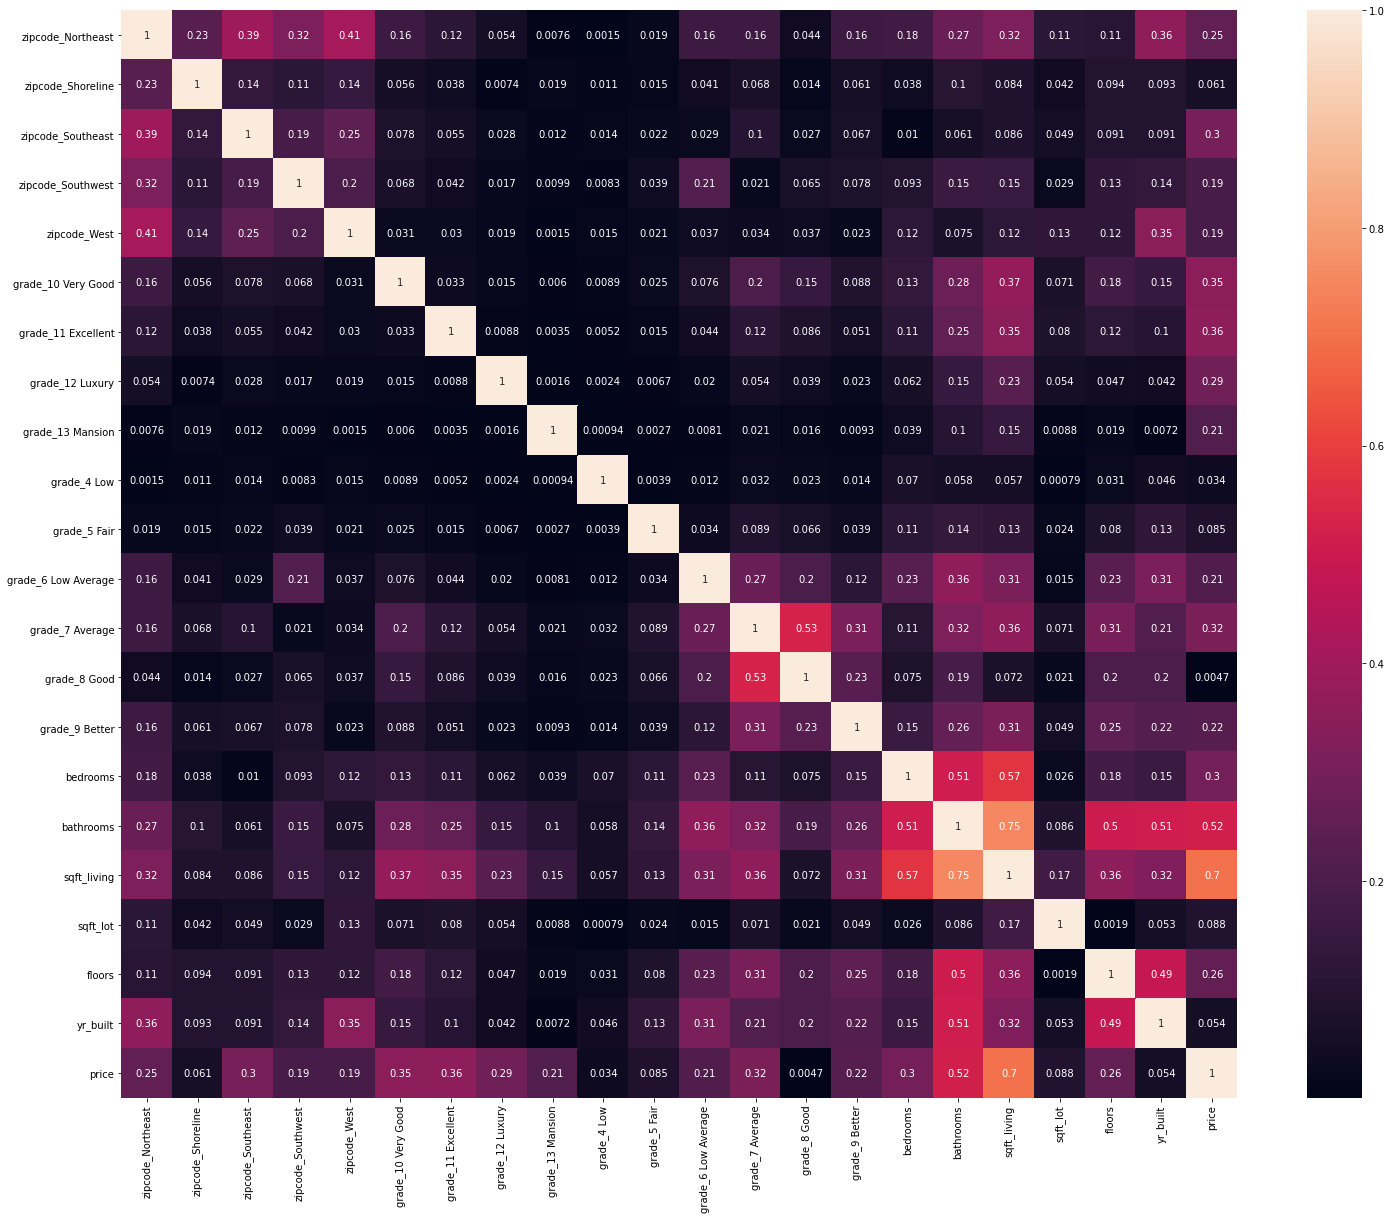

In [78]:
plt.figure(figsize = (25, 20))
sns.heatmap(combined_df.corr().abs(), annot=True);

As we can see from the df_corrs and the heatmap generated above, there is little to no correlation between the categorical variables we identified (grade/zipcode/floors) and their effect on price.

In [86]:
lr = LinearRegression()
model4 = lr.fit(X_train_predictors, y_train)
model4.score(X_train_predictors, y_train)

0.7016031747477318

In [87]:
y_pred_model = lr.predict(X_train_predictors.values)

In [88]:
sk_metrics(y_train, y_pred_model)

Metrics:
R2: 0.702
Mean Absolute Error: 118807.607
Mean Squared Error: 40430372946.267
Root Mean Squared Error: 201073.054


In [103]:
lr_model_metrics(X1_test, X1_train, y1_test, y1_train, ['grade','zipcode']);

Train Data
Metrics:
R2: 0.702
Mean Absolute Error: 118783.298
Mean Squared Error: 40429737661.469
Root Mean Squared Error: 201071.474
Test Data
Metrics:
R2: 0.702
Mean Absolute Error: 118921.240
Mean Squared Error: 39508992531.045
Root Mean Squared Error: 198768.691


This model is EXTREMELY overfit on the training dataset since all the assessment values are GIGANTIC.

## Model 5!!!

In [ ]:
qq(X1_test_cont, X1_train_cont, y1_test, y1_train)

In [ ]:
#y_hat2 = model.predict(X1_train_scaled)
#y_pred2 = model.predict(X1_test_scaled)

In [ ]:
'''plt.figure(figsize = (20,15))
plt.scatter(y_hat1, y_train - y_hat1, label = 'Training Set')
plt.scatter(y_pred1, y_test - y_pred1, label = 'Test Set')

plt.axhline(y = 0, color = 'red', label = '0')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.legend()
plt.show()'''

Markdown cell for new notebook push